<a href="https://colab.research.google.com/github/Hero0963/kaggle/blob/main/kaggle_explore_multi_label_classification/kaggle_explore_multi_label_classification_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Knowledge Regarding the Data  
https://www.kaggle.com/competitions/playground-series-s3e18/discussion/419646

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s3e18

import zipfile
import pandas as pd

# 解壓縮zip檔案
with zipfile.ZipFile('/content/playground-series-s3e18.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_folder')

rm: cannot remove '/root/.kaggle': No such file or directory
  0% 0.00/2.41M [00:00<?, ?B/s]
100% 2.41M/2.41M [00:00<00:00, 194MB/s]


In [ ]:
df_train = pd.read_csv('/content/extracted_folder/train.csv')
df_test = pd.read_csv('/content/extracted_folder/test.csv')
df_all = pd.concat([df_train, df_test], ignore_index=True)

# 判別是不是不平衡資料集  

In [ ]:
EC1_counts = df_train['EC1'].value_counts()
EC1_counts = EC1_counts.rename_axis('EC1').reset_index(name='Count')
print(EC1_counts.to_string(index=False))

 EC1  Count
   1   9908
   0   4930


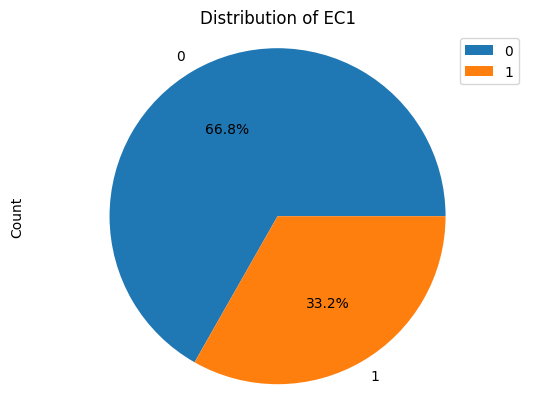

In [ ]:
import matplotlib.pyplot as plt


EC1_counts.plot(kind='pie', y='Count', autopct='%1.1f%%')
plt.axis('equal')  # 讓圖形呈現圓形
plt.title('Distribution of EC1')
plt.show()

In [ ]:
EC2_counts = df_train['EC2'].value_counts()
EC2_counts = EC2_counts.rename_axis('EC2').reset_index(name='Count')
print(EC2_counts.to_string(index=False))

 EC2  Count
   1  11855
   0   2983


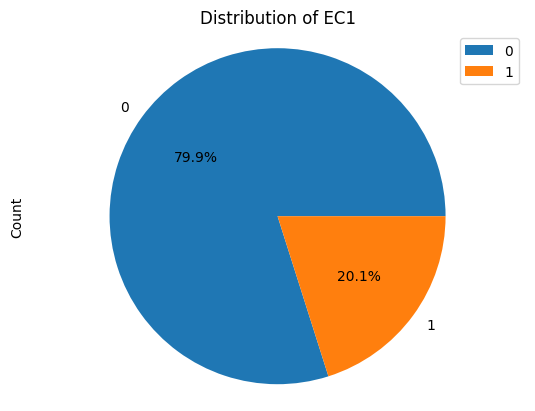

In [ ]:
import matplotlib.pyplot as plt


EC2_counts.plot(kind='pie', y='Count', autopct='%1.1f%%')
plt.axis('equal')  # 讓圖形呈現圓形
plt.title('Distribution of EC1')
plt.show()

In [ ]:
correlations_EC1 = df_train.corr()['EC1'].abs().sort_values(ascending=False)
correlations_EC2 = df_train.corr()['EC2'].abs().sort_values(ascending=False)
EC1_index_list = correlations_EC1.index.tolist()
EC2_index_list = correlations_EC2.index.tolist()
excluded_features = ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']

In [ ]:
selected_features_set = set()
for i in range(min(15, len(EC1_index_list))):
    feat = EC1_index_list[i]
    if feat not in excluded_features:
        selected_features_set.add(feat)

for i in range(min(15, len(EC2_index_list))):
    feat = EC2_index_list[i]
    if feat not in excluded_features:
        selected_features_set.add(feat)

In [ ]:
selected_features = [feat for feat in selected_features_set]
print(selected_features)

['EState_VSA1', 'VSA_EState9', 'EState_VSA2', 'fr_COO2', 'SMR_VSA10', 'PEOE_VSA8', 'HallKierAlpha', 'PEOE_VSA6', 'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA7', 'PEOE_VSA14', 'SMR_VSA5', 'MaxAbsEStateIndex', 'SlogP_VSA3', 'fr_COO', 'MinEStateIndex']


# modeling
ref = https://www.kaggle.com/code/kimtaehun/multi-label-classification-with-complete-eda/notebook

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold

target_cols = ['EC1', 'EC2']
# Create models for each target
models = {
    'xgb': {target: XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67) for target in target_cols},
}

# Dictionaries to store results
oof = {model: {target: [] for target in target_cols} for model in models.keys()}
auc_scores = {model: {target: [] for target in target_cols} for model in models.keys()}
best_iters = {model: {target: [] for target in target_cols} for model in models.keys()}
best_models = {model: {target: None for target in target_cols} for model in models.keys()}
best_auc = {model: {target: 0 for target in target_cols} for model in models.keys()}


# Training parameters
FOLDS = 5
SEED = 1004
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Training parameters
FOLDS = 5
SEED = 1004
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)


train = df_train
test = df_test
features = selected_features

# Train models
for model_name, model_dict in models.items():
    print(f'\033[1;34mTraining {model_name} models\033[0m')  # Blue for model names
    for target in target_cols:
        print(f'\033[1;32mTraining model for {target}\033[0m')  # Green for targets
        y = train[target]
        for fold, (train_idx, val_idx) in enumerate(skf.split(train, y)):
            print(f'\033[1;33m######################## Training FOLD {fold+1} ########################\033[0m')  # Yellow for fold numbers
            X_train, y_train = train.iloc[train_idx][features], y.iloc[train_idx]
            X_valid, y_valid = train.iloc[val_idx][features], y.iloc[val_idx]
            model = model_dict[target]
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=300, verbose=0)
            val_preds = model.predict_proba(X_valid)[:, 1]
            val_score = roc_auc_score(y_valid, val_preds)
            print(f'\033[1;35mauc: {val_score:.5f}\033[0m')  # Purple for AUC scores
            oof[model_name][target].append(val_preds)
            auc_scores[model_name][target].append(val_score)
            if model_name == 'xgb':  # XGBoost
                best_iters[model_name][target].append(model.get_booster().best_ntree_limit)
            elif model_name == 'lgb':  # LightGBM
                best_iters[model_name][target].append(model.best_iteration_)
            # Save the best model
            if val_score > best_auc[model_name][target]:
                best_auc[model_name][target] = val_score
                best_models[model_name][target] = model
        print(f'\033[1;31m*********************************************\033[0m')  # Red for separator
        print(f'\033[1;35mMean AUC for {target}: {np.mean(auc_scores[model_name][target]):.5f}\033[0m')  # Purple for mean AUC scores

Training xgb models
Training model for EC1
######################## Training FOLD 1 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.70752
######################## Training FOLD 2 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.70409
######################## Training FOLD 3 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.69941
######################## Training FOLD 4 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.69601
######################## Training FOLD 5 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.70600
*********************************************
Mean AUC for EC1: 0.70261
Training model for EC2
######################## Training FOLD 1 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.57033
######################## Training FOLD 2 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.59667
######################## Training FOLD 3 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.59029
######################## Training FOLD 4 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.57684
######################## Training FOLD 5 ########################


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


auc: 0.57501
*********************************************
Mean AUC for EC2: 0.58183


# Evaluation and Conclusion  

In [ ]:
# Create a DataFrame for average AUC scores
auc_df = pd.DataFrame(auc_scores)

# Calculate mean AUC for each model and target
auc_df = auc_df.applymap(np.mean)
# Format the numbers to 2 decimal places and apply a gradient color map
styled_auc_df = auc_df.style.format("{:.4f}").background_gradient(cmap='YlOrBr_r')

# Display the styled DataFrame
display(styled_auc_df)

,xgb
EC1,0.7026
EC2,0.5818


In [ ]:
def show_confusion_roc(preds: np.array, target: np.array) -> None:
    """Draws a confusion matrix and roc_curve with AUC score.

        Args:
            preds: Predictions from the model.
            target: True labels.

        Returns:
            None
    """

    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame({'preds': preds, 'target': target})
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, color='#20BEFF', ax=ax[1])
    plt.tight_layout()

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title('Feature importances', size=16, y=1.05,
              fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature',
                    palette='YlOrBr_r', linestyle="-",
                    linewidth=0.5, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')

    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
import seaborn as sns

Visualization for xgb EC1


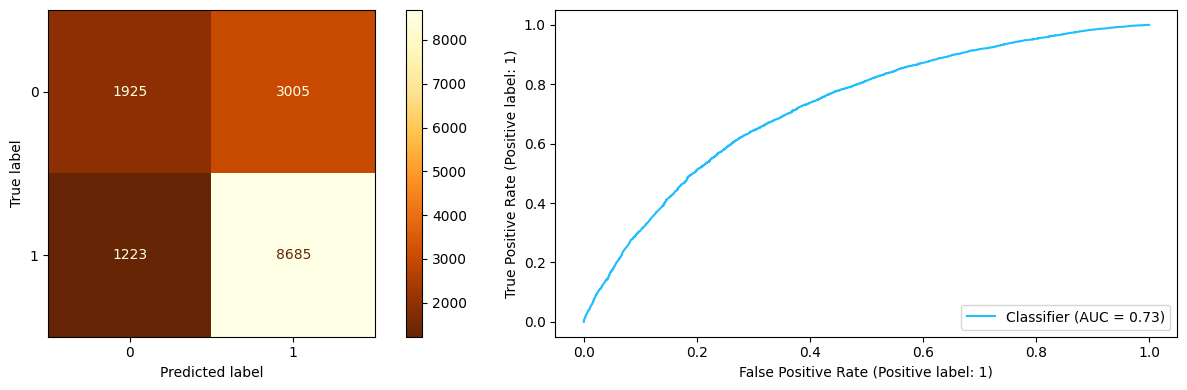

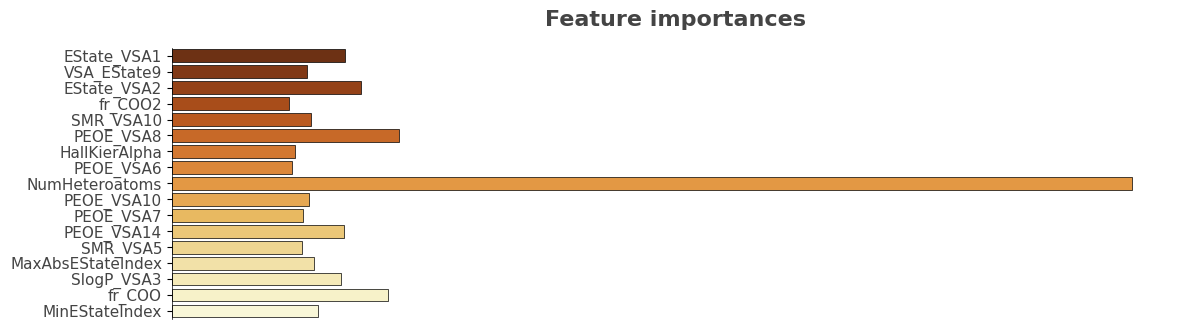

Visualization for xgb EC2


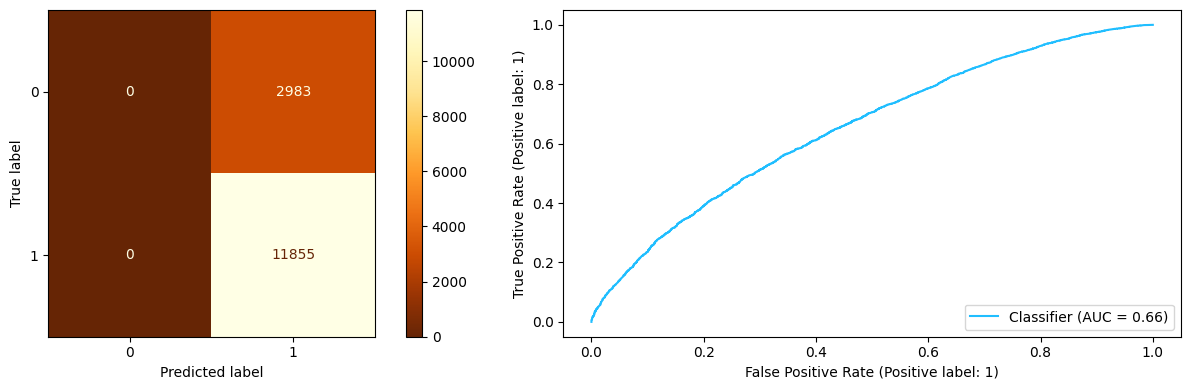

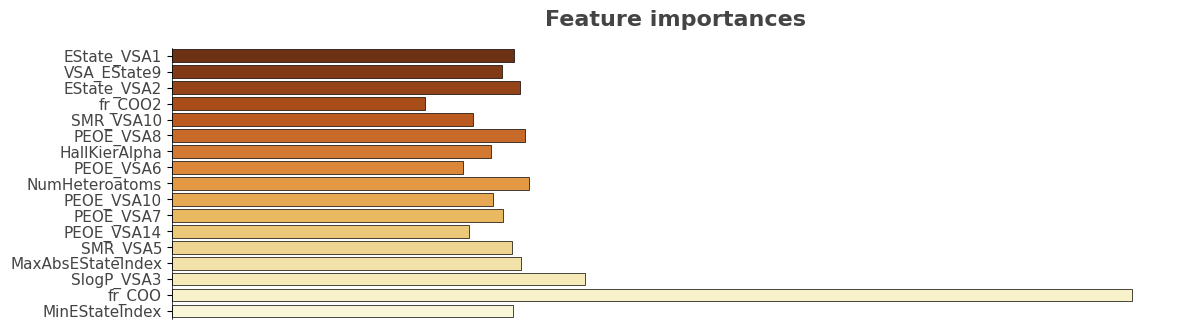

In [ ]:
for model_name, model_dict in best_models.items():
    for target in target_cols:
        print(f'\033[1;34;4mVisualization for {model_name} {target}\033[0m')  # Blue with underline for model and target
        best_val_preds = model_dict[target].predict_proba(train[features])[:, 1]
        show_confusion_roc(best_val_preds, train[target])
        f_imp_df = pd.DataFrame({'feature': features, 'avg_imp': model_dict[target].feature_importances_})
        f_importance_plot(f_imp_df)